     TICKER PER       DATE      TIME   CLOSE
0      SBER   D 2020-01-01  00:00:00  255.00
1      SBER   D 2020-01-04  00:00:00  255.00
2      SBER   D 2020-01-07  00:00:00  253.90
3      SBER   D 2020-01-09  00:00:00  259.15
4      SBER   D 2020-01-10  00:00:00  257.99
...     ...  ..        ...       ...     ...
1265   SBER   D 2025-01-28  00:00:00  275.23
1266   SBER   D 2025-01-29  00:00:00  278.35
1267   SBER   D 2025-01-30  00:00:00  280.36
1268   SBER   D 2025-01-31  00:00:00  281.97
1269   SBER   D 2025-02-01  00:00:00  280.73

[1270 rows x 5 columns]
data  c заполненными пропусками=
             target
2020-01-01  255.00
2020-01-02  255.00
2020-01-03  255.00
2020-01-04  255.00
2020-01-05  255.00
...            ...
2025-01-28  275.23
2025-01-29  278.35
2025-01-30  280.36
2025-01-31  281.97
2025-02-01  280.73

[1859 rows x 1 columns]
за 4 года =        timestamp  target item_id
0    2020-01-01  255.00    SBER
1    2020-01-02  255.00    SBER
2    2020-01-03  255.00    SBER
3    20

ValueError: 'x' has size 32, but 'y1' has an unequal size of 31

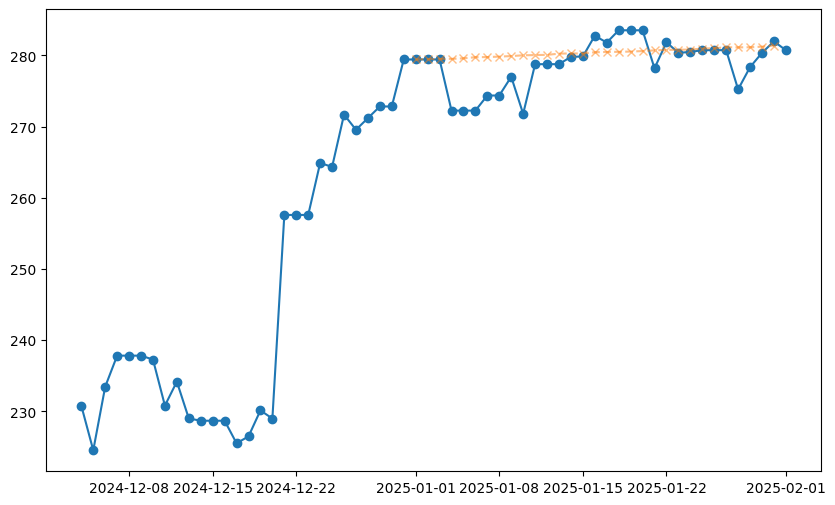

In [3]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy import stats
#неочищенный ряд
ticker = 'SBER'
file_path = 'SBER.xlsx'
df = pd.read_excel(file_path, skiprows=0, names=['TICKER', 'PER', 'DATE', 'TIME', 'CLOSE'])
print(df)
# Преобразование даты в правильный формат
df['DATE'] = pd.to_datetime(df['DATE'], format='%d.%m.%y')
df['timestamp'] = df['DATE']

# Создание DataFrame с необходимыми колонками
data = df[
    ['timestamp','CLOSE']
].rename(columns={'CLOSE': 'target'})
data = data.set_index('timestamp')
# Создаем регулярный временной ряд
full_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(full_dates)
data = data.ffill()

print("data  c заполненными пропусками=\n", data)
ts_data = data.reset_index()
ts_data.columns = ['timestamp', 'target']
ts_data['item_id'] = ticker
freq = 'D'

# Разделение на train/test (последние 30 дней - тест)
train_data = ts_data[ts_data['timestamp'] < '2025-01-01']
test_data = ts_data[ts_data['timestamp'] >= '2025-01-01']

print("за 4 года = ",train_data)
series=train_data['target']
print(series)

S0 = series.iloc[-1]
print(S0)


#log_returns = np.log(series / series.shift(1))
log_returns =series.pct_change()
mu = log_returns.mean()*365 #так как данные интерполирвоаны на 1 полный год - везде умножаем на 365, а 1 день = 1/365
print('mu = ',mu)
sigma = np.sqrt(log_returns.var()*365)
print('sigma=',sigma)
T=1
dt = T/365   # Размер шага по времени

t_intervals = 31 #на сколько дней прогноз
iterations = 10000 #серии итераций
# Генерация случайных приращений
dW = norm.ppf(np.random.rand(t_intervals, iterations))*np.sqrt(dt)
S = np.zeros_like(dW)
S[0] = S0

for i in range(1, t_intervals):
    #S[i] = S[i - 1] + drift * S[i - 1] * dt + volatility * S[i - 1] * dW[i - 1]
    S[i] = S[i - 1] + mu * S[i - 1] * dt + sigma * S[i - 1] * dW[i - 1]
    #S[i] = S[i - 1] + mu * dt + sigma  * dW[i - 1]
print(S)
df = pd.DataFrame(S)


quantile_95 = df.mean(axis=1)
print("95%-й квантиль конечных цен:", quantile_95)

s = pd.Series(quantile_95)
s.to_csv('прогноз_неочищ.csv', index=False)

lower_bound = np.percentile(df, 10, axis=1)  # 5-й перцентиль (нижняя граница)
upper_bound = np.percentile(df, 90, axis=1)
test1=test_data.reset_index()
test1.insert(1, 'prognoz_MC', quantile_95)

plt.figure(figsize=(10, 6))

plt.plot(
    ts_data['timestamp'].tail(60),
    ts_data['target'].tail(60),
    label='Actual data',
    marker='o',
    linestyle='-'
)


plt.plot(
    test1['timestamp'],
    test1['prognoz_MC'],
    label='Prediction',
    alpha=0.5,
    linestyle='--',
    marker='x'
)
# Визуализация интервалов
plt.fill_between(
test1['timestamp'],
    #confidence_interval[0],
    #confidence_interval[1],
lower_bound,
    upper_bound,
    color='b',
    alpha=0.1,

    label='90% confidence interval'
)


plt.xlabel('Date')
plt.ylabel('The price of the stock')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(len(test_data))
print(len(quantile_95))
#

s2 = pd.Series(test1['target'])
s2.to_csv('исходные_январь_25.csv', index=False)
print(test1['target'] - test1['prognoz_MC'])

print('МЕТРИКИ на 5 ДНЕЙ')
# Расчет MAE
mae = np.mean(np.abs(test1['target'][:5] - test1['prognoz_MC'][:5]))
print(f"MAE: {mae:.2f}")


# Расчет MAPE
mape = np.mean(np.abs((test1['target'][:5] - test1['prognoz_MC'][:5]) / test1['target'][:5])) * 100
print(f"MAPE: {mape:.2f}%")

# Расчет RMSE
rmse = np.sqrt(np.mean((test1['target'][:5] - test1['prognoz_MC'][:5])**2))
print(f"RMSE: {rmse:.2f}%")

print('МЕТРИКИ на 15 ДНЕЙ')
# Расчет MAE
mae = np.mean(np.abs(test1['target'][:15] - test1['prognoz_MC'][:15]))
print(f"MAE: {mae:.2f}")


# Расчет MAPE
mape = np.mean(np.abs((test1['target'][:15] - test1['prognoz_MC'][:15]) / test1['target'][:15])) * 100
print(f"MAPE: {mape:.2f}%")

# Расчет RMSE
rmse = np.sqrt(np.mean((test1['target'][:15] - test1['prognoz_MC'][:15])**2))
print(f"RMSE: {rmse:.2f}%")

print('МЕТРИКИ на 31 ДЕНЬ')

# Расчет MAE
mae = np.mean(np.abs(test1['target'][:31] - test1['prognoz_MC'][:31]))
print(f"MAE: {mae:.2f}")


# Расчет MAPE
mape = np.mean(np.abs((test1['target'][:31] - test1['prognoz_MC'][:31]) / test1['target'][:31])) * 100
print(f"MAPE: {mape:.2f}%")

# Расчет RMSE
rmse = np.sqrt(np.mean((test1['target'][:31] - test1['prognoz_MC'][:31])**2))
print(f"RMSE: {rmse:.2f}%")

plt.figure(figsize=(10,6))
plt.plot(S)
plt.show()